In [204]:
from copy import deepcopy
from time import sleep

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

https://openai.com/requests-for-research/#cartpole

## Explore `gym` and the `CartPole-v0` environment

In [2]:
env = gym.envs.make('CartPole-v0')

/home/mkurovski/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
env.reset()

array([ 0.0207682 , -0.0382533 ,  0.01408467,  0.00032193])

In [4]:
env.action_space

Discrete(2)

In [5]:
env.action_space.contains(0)

True

In [6]:
env.action_space.contains(1)

True

In [7]:
env.observation_space

Box(4,)

In [8]:
env.step(0)

(array([ 0.02000313, -0.23357438,  0.01409111,  0.29741525]), 1.0, False, {})

In [9]:
action = 0

In [10]:
next_state, reward, done, _ = env.step(action)
if not done:
    print("Reward:", reward)

Reward: 1.0


Watch a random agent

In [11]:
for i in range(200):
    env.render()
    sleep(0.1)
    action = np.random.randint(2)
    next_state, reward, done, _ = env.step(action)
    if done:
        env.reset()

env.close()

## Simple Neural Network Approach

In [241]:
class Agent(torch.nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size_1):
        super(Agent, self).__init__()
        self.actions = list(range(action_size))
        self.linear_1 = torch.nn.Linear(state_size, hidden_size_1)
        self.linear_2 = torch.nn.Linear(hidden_size_1, action_size)
        self.softmax = torch.nn.Softmax(dim=0)
        
    def _forward(self, state: np.ndarray):
        x = torch.from_numpy(state).float()
        x = self.linear_1(x)
        x = self.linear_2(x)
        
        return self.softmax(x)
        
    def get_action(self, state):
        action_probabilities = self._forward(state).detach().numpy()
        # sample an action according to the softmax probabilities (stochastic policy)
        action = np.random.choice(self.actions, size=1, p=action_probabilities)[0]
        
        return action
        
    def get_params(self):
        params = dict.fromkeys(['weights_1', 'biases_1',
                                'weights_2', 'biases_2'])
        params['weights_1'] = self.linear_1.weight.detach()
        params['biases_1'] = self.linear_1.bias.detach()
        params['weights_2'] = self.linear_2.weight.detach()
        params['biases_2'] = self.linear_2.bias.detach()
        
        return params
        
    def set_params(self, new_params: dict):
        cartpole_agent.linear_1.weight = torch.nn.Parameter(new_params['weights_1'])
        cartpole_agent.linear_1.bias = torch.nn.Parameter(new_params['biases_1'])
        cartpole_agent.linear_2.weight = torch.nn.Parameter(new_params['weights_2'])
        cartpole_agent.linear_2.bias = torch.nn.Parameter(new_params['biases_2'])

In [242]:
def add_noise(params: dict, noise_std: float=0.1, noise_mean: float=0.):
    params_cand = deepcopy(params)
    for key, val in params_cand.items():
        shape = val.shape
        params_cand[key] = val + (torch.randn(shape)*noise_std + noise_mean)
    
    return params_cand

In [243]:
def perform_hill_climbing(agent, env, n_episodes: int=500,
                          initial_noise_std: float=0.1, initial_noise_mean: float=0.0):
    """Performs Basic Hill Climbing Algorithm
    
    Args:
        n_episodes: number of episodes for trying out adapted weights
    
    """
    noise_std = initial_noise_std
    noise_mean = initial_noise_mean
    
    best_params = agent.get_params()
    G_best = 0  # estimated return of current policy
    
    state = env.reset()
    # TODO: move into separate method (DRY-principle)
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        G_best += reward
        state = next_state
        if done:
            state = env.reset()
            break
    
    print("Start with Return Estimate G = %s" %G_best)
    
    return_history = [G_best]
    for episode in range(n_episodes):
        params_cand = add_noise(best_params)
        agent.set_params(params_cand)
        
        G = 0
        while True:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            G += reward
            state = next_state
            if done:
                state = env.reset()
                break
                
        if G > G_best:
            G_best = G
            best_params = params_cand
            print("Episode %  s - Improved G to G_best = %s" %(episode, G_best))
        
        agent.set_params(best_params)
        return_history.append(G)
            
    return agent, return_history

## Apply Hill Climbing Algorithm to solve Environment

In [257]:
torch.random.manual_seed(42)

In [258]:
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 2000
initial_noise_std = 0.05

In [259]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  initial_noise_std=initial_noise_std)

Start with Return Estimate G = 37.0
Episode 6 - Improved G to G_best = 43.0
Episode 27 - Improved G to G_best = 89.0
Episode 172 - Improved G to G_best = 95.0
Episode 440 - Improved G to G_best = 97.0
Episode 444 - Improved G to G_best = 105.0
Episode 480 - Improved G to G_best = 114.0
Episode 646 - Improved G to G_best = 116.0
Episode 676 - Improved G to G_best = 133.0
Episode 821 - Improved G to G_best = 145.0
Episode 828 - Improved G to G_best = 176.0
Episode 954 - Improved G to G_best = 197.0
Episode 977 - Improved G to G_best = 200.0


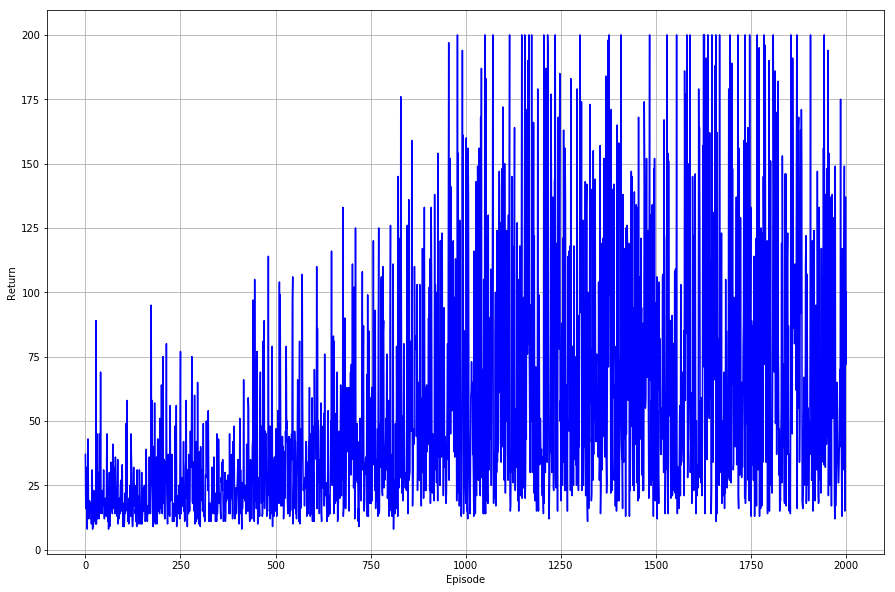

In [260]:
plt.figure(figsize=(15,10))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

Watch a (slightly) improved agent

In [261]:
state = env.reset()
for i in range(2000):
    env.render()
    action = opt_agent.get_action(state)
    state, reward, done, _ = env.step(action)
    if done:
        state = env.reset()

env.close()

## Apply diverse Improvements to Hill Climbing